## Oil Price Prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt




In [2]:
# Read CSV file without creating an index column and parse dates
df = pd.read_csv('./DCOILBRENTEU.csv', index_col=0, parse_dates=['DATE'])

# Rename 'DCOILBRENTEU' column to 'Price'
df.rename(columns={'DCOILBRENTEU': 'Target'}, inplace=True)

df = df[~df['Target'].astype(str).str.contains('^\.+$')]

# Convert to float
df['Target'] = df['Target'].astype(float)
df

,Target
DATE,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2023-08-08,88.00
2023-08-09,89.31
2023-08-10,87.44


<Axes: xlabel='DATE'>

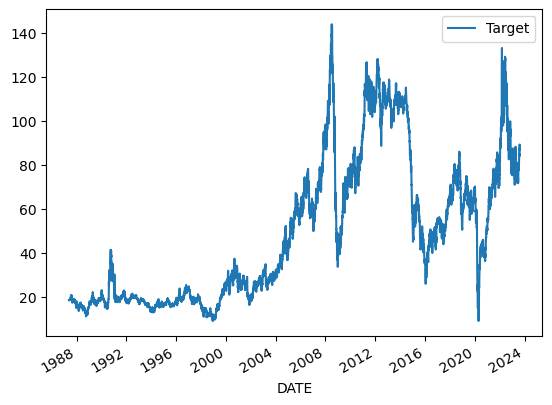

In [3]:
df.plot()

# Feature engineering
- Lagged Features
- Rolling window
- Dates
- Exponential moving average
- Differences

In [4]:
# Lagged features
df['lag_1'] = df['Target'].shift(1)
df['lag_2'] = df['Target'].shift(2)
df['lag_3'] = df['Target'].shift(3)
df['lag_7'] = df['Target'].shift(7)

# Rolling window
df['rolling_mean_7'] = df['Target'].rolling(window=7).mean()
df['rolling_std_7'] = df['Target'].rolling(window=7).std()

# Dates
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year
df['day_of_month'] = df.index.day
df['week_of_year'] = df.index.weekofyear

# Exponential moving average
df['ema_7'] = df['Target'].ewm(span=7, adjust=False).mean()
df['ema_14'] = df['Target'].ewm(span=14, adjust=False).mean()
df['ema_30'] = df['Target'].ewm(span=30, adjust=False).mean()

# Difference
df['day_diff'] = df['Target'].diff()

# Remove NaN from lag and rolling
df.dropna(inplace=True)

C:\Users\Lukas\AppData\Local\Temp\ipykernel_9540\2452803593.py:16: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week_of_year'] = df.index.weekofyear


In [5]:
df.head()

,Target,lag_1,lag_2,lag_3,lag_7,rolling_mean_7,rolling_std_7,day_of_week,month,year,day_of_month,week_of_year,ema_7,ema_14,ema_30,day_diff
DATE,,,,,,,,,,,,,,,,
1987-05-29,18.58,18.60,18.60,18.63,18.63,18.572857,0.059362,4,5,1987,29,22,18.592528,18.599220,18.610307,-0.02
1987-06-01,18.65,18.58,18.60,18.60,18.45,18.601429,0.032367,0,6,1987,1,23,18.606896,18.605991,18.612867,0.07
1987-06-02,18.68,18.65,18.58,18.60,18.55,18.620000,0.035119,1,6,1987,2,23,18.625172,18.615859,18.617199,0.03
1987-06-03,18.75,18.68,18.65,18.58,18.60,18.641429,0.058716,2,6,1987,3,23,18.656379,18.633744,18.625766,0.07
1987-06-04,18.78,18.75,18.68,18.65,18.63,18.662857,0.078042,3,6,1987,4,23,18.687284,18.653245,18.635717,0.03


In [6]:
# Splitting
test_size = 365 # 1 year

train = df.iloc[:-test_size] # all rows except test
test = df.iloc[-test_size:]

## Linear Regression and RandomForestRegressor

### LR
- RMSE: ~ 2.80

### RFR
- RMSE: ~ 1.90

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor



In [8]:
def model_training(model, train, test):
    # Splitting features and target
    X_train = train.drop('Target', axis=1)
    y_train = train['Target']
    X_test = test.drop('Target', axis=1)
    golds = test['Target']

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = mean_squared_error(golds, preds, squared=False)
    plot_preds(golds, preds)
    print(f'RMSE for {model}: \n {rmse:.3}')


In [9]:
# Visualizing
def plot_preds(gold, preds):
    plt.figure(figsize=(15,6))
    plt.plot(gold, label='Actual', color='blue')
    plt.plot(gold.index, preds, label='Predictions', color='orange', linestyle='dashed')
    plt.title('Actual vs Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

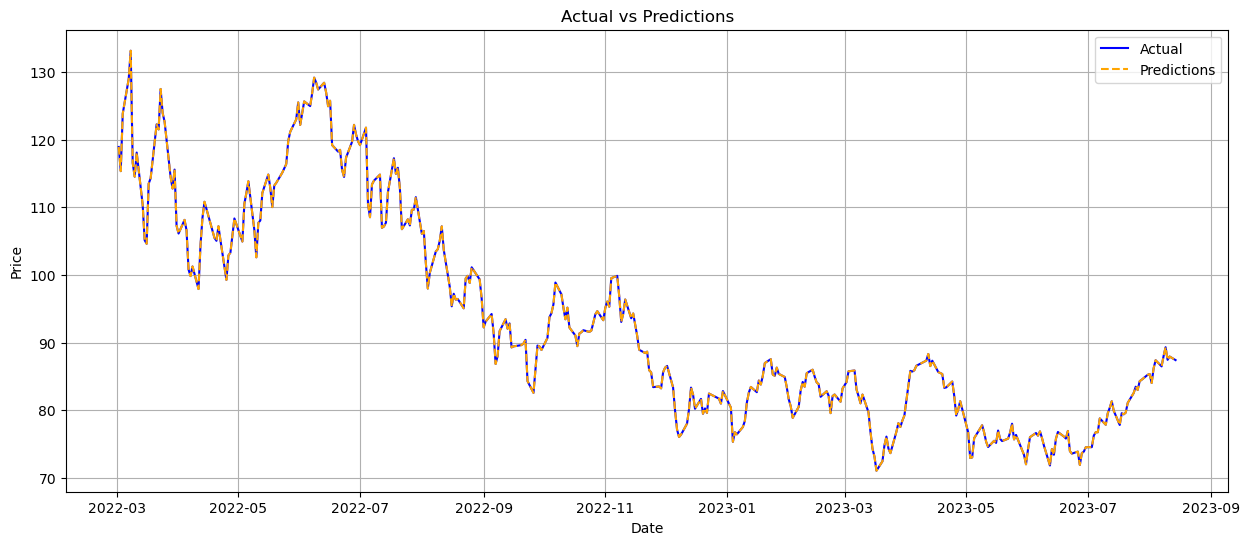

RMSE for LinearRegression(): 
 2.76e-14


In [10]:
model = LinearRegression()
model_training(model, train, test)

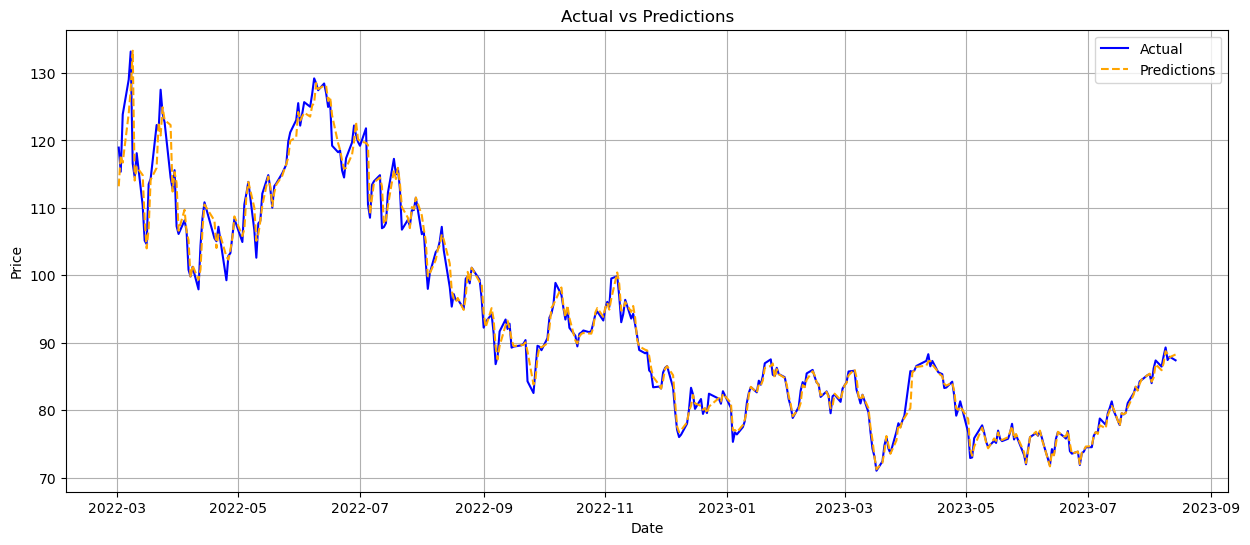

RMSE for RandomForestRegressor(min_samples_split=30, n_jobs=-1, random_state=99): 
 1.87


In [11]:
model = RandomForestRegressor(n_estimators=100, min_samples_split=30, n_jobs=-1, random_state=99)
model_training(model, train, test)

## LSTM

Tried a few different dimensions, dropout etc. Many options to explore.

Not overfitting at 100 epochs.

Current Test RMSE: ~ 0.5

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset



c:\Users\Lukas\miniconda3\envs\LSDA\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
from sklearn.preprocessing import StandardScaler

# Splitting
test_size = 365 # 1 year

train = df.iloc[:-test_size] # all rows except test
test = df.iloc[-test_size:]

# Scaling the data
scaler = StandardScaler()
# Only fit on the training data
scaler.fit(train.drop('Target', axis=1))
# Transform both training and test data
scaled_train = scaler.transform(train.drop('Target', axis=1))
scaled_test = scaler.transform(test.drop('Target', axis=1))

# Tensors
X_train = torch.tensor(scaled_train).float()
y_train = torch.tensor(train['Target'].values).float().unsqueeze(1) # Adding a dimension for batch training

X_test = torch.tensor(scaled_test).float()
y_test = torch.tensor(test['Target'].values).float().unsqueeze(1)
# DataLoaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

In [14]:
# Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=0.2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        x = x.unsqueeze(1)
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.linear(out[:, -1, :])
        return out


In [15]:
# Parameters
input_dim = X_train.shape[1]
hidden_dim = 128
num_layers = 2
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

# RMSE to compare
def rmse(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

In [16]:
# Training loop

train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_func(outputs, target)
        running_loss += torch.sqrt(loss) * data.size(0) # RMSE
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1} / {num_epochs}, Training RMSE: {epoch_loss:.2f}, Training loss: {loss.item():.2f}')

Epoch 1 / 100, Training RMSE: 43.86, Training loss: 742.67
Epoch 2 / 100, Training RMSE: 26.58, Training loss: 168.03
Epoch 3 / 100, Training RMSE: 18.83, Training loss: 466.30
Epoch 4 / 100, Training RMSE: 13.88, Training loss: 176.97
Epoch 5 / 100, Training RMSE: 10.44, Training loss: 18.81
Epoch 6 / 100, Training RMSE: 7.89, Training loss: 14.27
Epoch 7 / 100, Training RMSE: 5.89, Training loss: 7.79
Epoch 8 / 100, Training RMSE: 4.39, Training loss: 21.08
Epoch 9 / 100, Training RMSE: 3.33, Training loss: 2.75
Epoch 10 / 100, Training RMSE: 2.66, Training loss: 3.96
Epoch 11 / 100, Training RMSE: 2.27, Training loss: 0.80
Epoch 12 / 100, Training RMSE: 2.01, Training loss: 1.91
Epoch 13 / 100, Training RMSE: 1.82, Training loss: 0.95
Epoch 14 / 100, Training RMSE: 1.64, Training loss: 0.49
Epoch 15 / 100, Training RMSE: 1.54, Training loss: 1.07
Epoch 16 / 100, Training RMSE: 1.43, Training loss: 2.40
Epoch 17 / 100, Training RMSE: 1.32, Training loss: 2.17
Epoch 18 / 100, Training

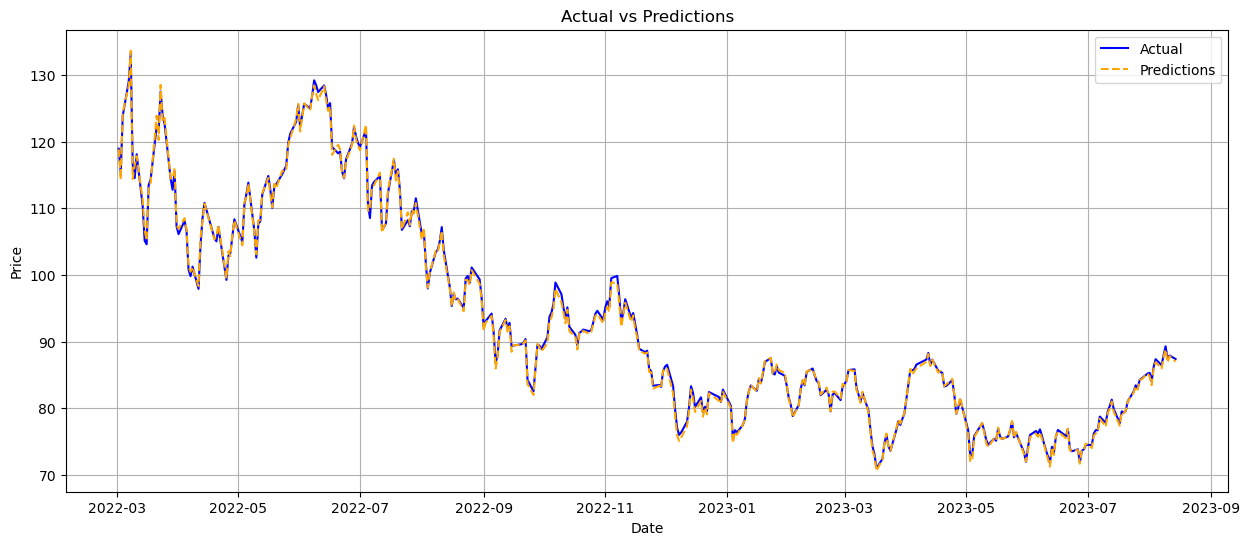

Test RMSE: 0.51


In [17]:
# Evaluation
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)
    test_rmse = rmse(test_predictions, y_test)
    plot_preds(test['Target'], test_predictions)
    print(f'Test RMSE: {test_rmse:.2f}')